In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import scipy.stats as stats
import healpy as hp
import matplotlib.pyplot as plt
from astropy.io import fits

from psf_systematic import sample_sys_map, sys_map

from getdist import plots, MCSamples

%matplotlib inline


In [2]:
path_star = '/n17data/mkilbing/astro/data/CFIS/v1.0/SP_LFmask/unions_shapepipe_star_2022_v1.3_mtheli8k.fits'

cat_star = fits.getdata(path_star)
cat_star

FITS_rec([( 358.89885746, 2446.11664642, 1.52552805e-04, 30.12733569,  0.0129933 ,  0.0412099 , 0.1636143 , 0.,  0.01974397,  0.0392343 , 0.16165558, 0., 37, 10948.89885746,  2446.11664642, 2),
          ( 849.6441065 ,  305.71407961, 1.83427440e-04, 35.3238229 ,  0.02594059, -0.00152456, 0.24799119, 0.,  0.02164121,  0.00604323, 0.26240393, 0., 39, 11439.6441065 , -4731.28592039, 2),
          (1261.59376847, 2185.80994189, 2.18055717e-04, 36.47363072, -0.02881248, -0.02361506, 0.27560765, 0., -0.02347908, -0.02862917, 0.27744309, 0., 34,  7615.59376847, -7888.19005811, 2),
          ...,
          (1683.33632077, 2995.27141093, 3.59999722e+02, 32.71327966,  0.0315252 ,  0.03584299, 0.14458114, 0.,  0.03199921,  0.0330251 , 0.14627586, 0.,  4,  1683.33632077,  8032.27141093, 2),
          ( 778.82544741, 3018.22771083, 3.59999850e+02, 34.07760299,  0.0194183 ,  0.07835089, 0.14042773, 0.,  0.01359442,  0.07209492, 0.14198866, 0., 17,  9250.82544741,  3018.22771083, 2),
          (1263

In [3]:
config = {
    'ra_col': 'RA',
    'dec_col': 'DEC',
    'e1_psf_col': 'E1_PSF_HSM',
    'e2_psf_col': 'E2_PSF_HSM',
    'size_psf_col': 'T_PSF_HSM',
    'e1_star_col': 'E1_STAR_HSM',
    'e2_star_col': 'E2_STAR_HSM',
    'size_star_col': 'T_STAR_HSM',
    'square_size': False,
    'hdu': 1
}

prior = {
    'alpha': [-0.01, 0.01],
    'beta': [0.80, 1.20],
    'eta': [-1.0, 1.0],
}

In [4]:
nside=512

ra = cat_star[config['ra_col']]
dec = cat_star[config['dec_col']]
e1_psf = cat_star[config['e1_psf_col']]
e2_psf = cat_star[config['e2_psf_col']]
size_psf = cat_star[config['size_psf_col']]**2 if config['square_size'] else cat_star[config['size_psf_col']]
e1_star = cat_star[config['e1_star_col']]
e2_star = cat_star[config['e2_star_col']]
size_star = cat_star[config['size_star_col']]**2 if config['square_size'] else cat_star[config['size_star_col']]

#Create a map of the stars
theta = (90 - dec) * np.pi / 180
phi = ra * np.pi / 180
pix = hp.ang2pix(nside, theta, phi)

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)

n_star = np.zeros(hp.nside2npix(nside))

n_star[unique_pix] += np.bincount(idx_rep)

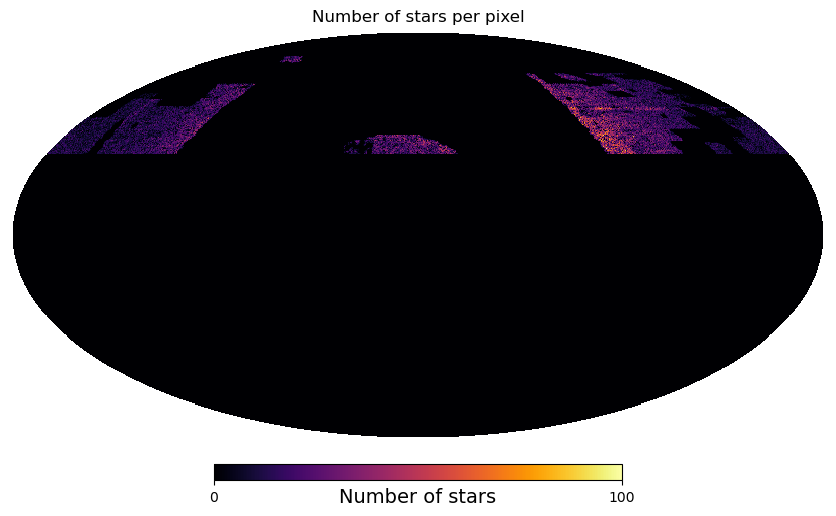

In [5]:
hp.mollview(n_star, title='Number of stars per pixel', unit='Number of stars', cmap='inferno')
plt.show()

In [9]:
samples_sys = np.load('/home/guerrini/sp_validation/notebooks/cosmo_val/output/rho_tau_stats/samples_SP_v1.3_LFmask_8k.npy')

In [23]:
prior = {}

for i in range(1, 6):
    prior[f'bin{i}'] = {}
    prior[f'bin{i}']['mean'] = np.mean(samples_sys, axis=0)
    prior[f'bin{i}']['cov'] = np.cov(samples_sys.T)

In [24]:
proposal = stats.multivariate_normal(mean=prior['bin1']['mean'], cov=prior['bin1']['cov'])

In [25]:
test_samples = proposal.rvs(size=10000)

Removed no burn in


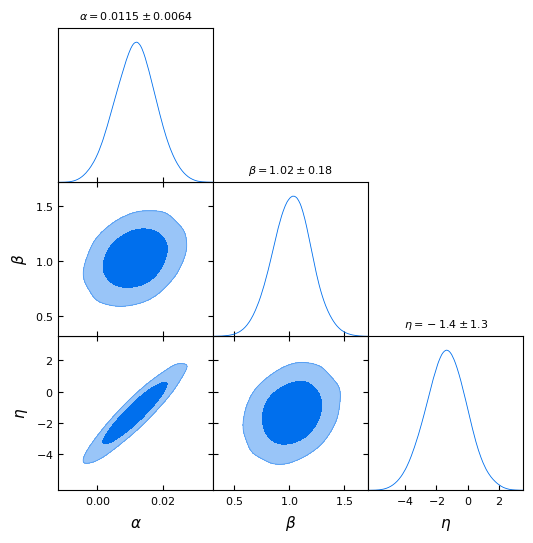

In [26]:
test_samples_gd = MCSamples(samples=test_samples, names=['\alpha', '\beta', '\eta'], labels=['\\alpha', '\\beta', '\\eta'])

g = plots.get_subplot_plotter()

g.triangle_plot(test_samples_gd, filled=True, title_limit=1)

plt.show()

In [27]:
np.save('/home/guerrini/UNIONS_forward_model/data_utils/prior_psf_sys_SP_v1.3_LFmask_8k.npy', prior)

In [28]:
prior = np.load('/home/guerrini/UNIONS_forward_model/data_utils/prior_psf_sys_SP_v1.3_LFmask_8k.npy', allow_pickle=True).item()

In [31]:
prior

{'bin1': {'mean': array([ 0.01151804,  1.02747736, -1.36876179]),
  'cov': array([[4.08082456e-05, 3.13355876e-04, 7.78751432e-03],
         [3.13355876e-04, 3.18909934e-02, 5.66156980e-02],
         [7.78751432e-03, 5.66156980e-02, 1.72488021e+00]])},
 'bin2': {'mean': array([ 0.01151804,  1.02747736, -1.36876179]),
  'cov': array([[4.08082456e-05, 3.13355876e-04, 7.78751432e-03],
         [3.13355876e-04, 3.18909934e-02, 5.66156980e-02],
         [7.78751432e-03, 5.66156980e-02, 1.72488021e+00]])},
 'bin3': {'mean': array([ 0.01151804,  1.02747736, -1.36876179]),
  'cov': array([[4.08082456e-05, 3.13355876e-04, 7.78751432e-03],
         [3.13355876e-04, 3.18909934e-02, 5.66156980e-02],
         [7.78751432e-03, 5.66156980e-02, 1.72488021e+00]])},
 'bin4': {'mean': array([ 0.01151804,  1.02747736, -1.36876179]),
  'cov': array([[4.08082456e-05, 3.13355876e-04, 7.78751432e-03],
         [3.13355876e-04, 3.18909934e-02, 5.66156980e-02],
         [7.78751432e-03, 5.66156980e-02, 1.724880